In [39]:
import yfinance as yf
import pandas as pd
import finanzas_utils as utils

# 1. Input: Tickers
t1 = input("Introducir el primer ticker").upper()
t2 = input("Introduce el segundo ticker").upper()
lista_tickers = [t1, t2]

# 2. Proceso: Descargamos datos
print(f"Descarga de datos de {lista_tickers}...")
datos = yf.download(lista_tickers, period="1y")['Close']
resultados = {}

for ticker in lista_tickers:
    print(f"\nAnalizando {ticker}...")
    serie = datos[ticker]

    retorno_anual = utils.calcular_retorno_diario(serie.iloc[-1], serie.iloc[0])

    retorno_mensual = utils.calcular_retorno_diario(serie.iloc[-1], serie.iloc[-22])

    # Volatilidad
    cambios_diarios = serie.pct_change().dropna() * 100
    std_diaria = cambios_diarios.std()

    categoria = utils.categorizar_volatilidad(std_diaria)

    # Guardamos datos
    resultados[ticker] = {
        'retorno_anual': retorno_anual,
        'retorno_mensual': retorno_mensual,
        'volatilidad': std_diaria,
        'cat_vol': categoria
    }

    print(f"Rendimiento Anual: {retorno_anual:.2f}%")
    print(f"Rendimiento Mensual: {retorno_mensual:.2f}%")
    print(f"Volatilidad: {std_diaria:.2f}% -> {categoria}")

# 3. Output
mejor_anio = t1 if resultados[t1]['retorno_anual'] > resultados[t2]['retorno_anual'] else t2
mejor_mes = t1 if resultados[t1]['retorno_mensual'] > resultados[t2]['retorno_mensual'] else t2

print("\n--- RESUMEN COMPARATIVO ---")
print(f"En el último año, {mejor_anio} ha tenido mejor comportamiento.")
print(f"En el último mes, el ganador ha sido {mejor_mes}.")
print(f"Volatilidades: {t1} ({resultados[t1]['cat_vol']}) vs {t2} ({resultados[t2]['cat_vol']})")

Introducir el primer tickering
Introduce el segundo tickerbnp.pa
Descarga de datos de ['ING', 'BNP.PA']...


/tmp/ipython-input-1987750371.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos = yf.download(lista_tickers, period="1y")['Close']
[*********************100%***********************]  2 of 2 completed


Analizando ING...
Rendimiento Anual: 88.56%
Rendimiento Mensual: 6.64%
Volatilidad: 1.67% -> Baja

Analizando BNP.PA...
Rendimiento Anual: 60.51%
Rendimiento Mensual: 12.95%
Volatilidad: 1.80% -> Baja

--- RESUMEN COMPARATIVO ---
En el último año, ING ha tenido mejor comportamiento.
En el último mes, el ganador ha sido BNP.PA.
Volatilidades: ING (Baja) vs BNP.PA (Baja)



/tmp/ipython-input-1987750371.py:24: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  cambios_diarios = serie.pct_change().dropna() * 100


/tmp/ipython-input-2713798358.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(activo, period="2y")[['Close']]
[*********************100%***********************]  1 of 1 completed


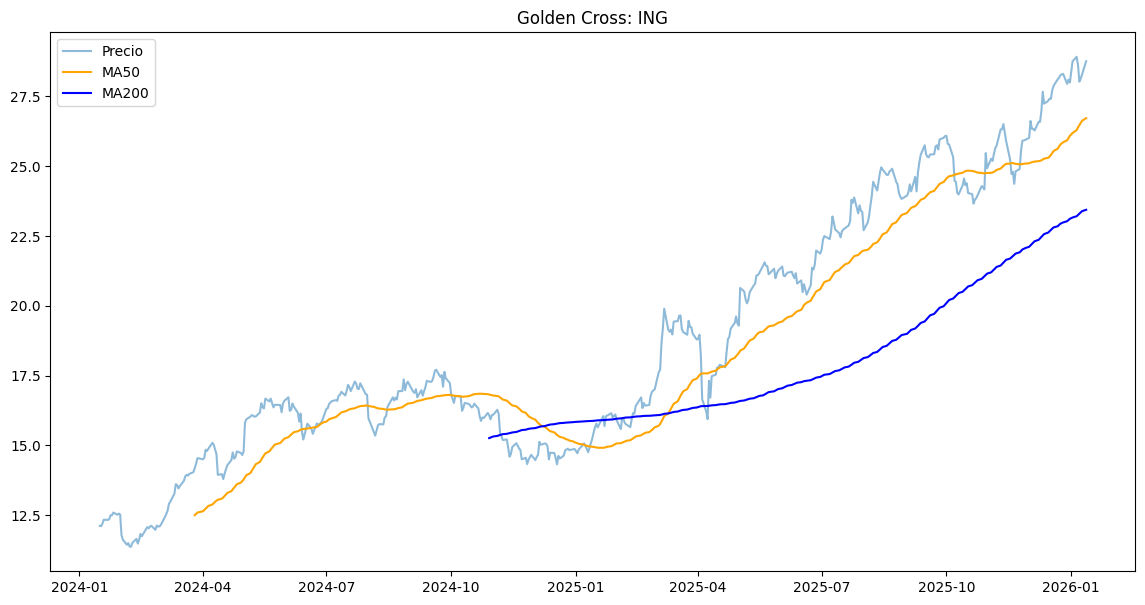

Golden Cross detectado en 1 ocasiones:
 -> 2025-03-11


In [40]:
import matplotlib.pyplot as plt
import yfinance as yf

# Primer ticker
activo = t1
df = yf.download(activo, period="2y")[['Close']]

# 1. Medias moviles
df['MA50'] = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()

# 2. Gráfico
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Precio', alpha=0.5)
plt.plot(df.index, df['MA50'], label='MA50', color='orange')
plt.plot(df.index, df['MA200'], label='MA200', color='blue')

plt.title(f'Golden Cross: {activo}')
plt.legend()
plt.show()

# 3. Puntos de cruce (Golden Cross: MA50 cruza hacia arriba MA200)
condicion = (df['MA50'] > df['MA200']) & (df['MA50'].shift(1) < df['MA200'].shift(1))
puntos_cruce = df[condicion]

if not puntos_cruce.empty:
    print(f"Golden Cross detectado en {len(puntos_cruce)} ocasiones:")
    for fecha in puntos_cruce.index:
        print(f" -> {fecha.strftime('%Y-%m-%d')}")
else:
    print("No se ha producido ningún Golden Cross en este periodo.")

/tmp/ipython-input-3205032125.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_limpio = yf.download(activo, start="2023-01-01", end="2025-12-31")['Close']
[*********************100%***********************]  1 of 1 completed

Valores nulos generados: 345


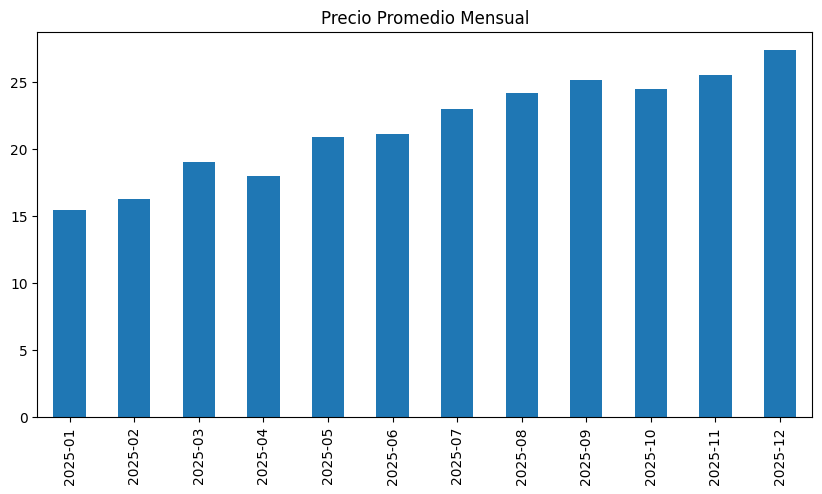

In [44]:
# Datos del 2023 al 2025
df_limpio = yf.download(activo, start="2023-01-01", end="2025-12-31")['Close']

# 1. Rango con dias (sabados y domingos)
rango_fechas = pd.date_range(start="2023-01-01", end="2025-12-31", freq="D")

# Reindex
df_limpio = df_limpio.reindex(rango_fechas)

# 2. Contar valores nulos
nulos = df_limpio.isnull().sum().item()
print(f"Valores nulos generados: {nulos}")

# 3. Forward Fill
df_limpio.ffill(inplace=True)

# 4. Frecuencia Mensual (resample) y media
df_mensual = df_limpio.resample('ME').mean()

# 5. Grafico ulitmos 12 meses
df_plot = df_mensual.iloc[-12:].copy()
df_plot.index = df_plot.index.strftime('%Y-%m')
df_plot.plot(kind='bar', figsize=(10, 5), title='Precio Promedio Mensual', legend=False)
plt.show()

In [64]:
import pandas as pd
import requests
from io import StringIO

# 1. Datos de web (Wikipedia)
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
# User-Agent para usar web browser (Chrome, Safari)
headers = {'User-Agent': 'Chrome/91.0.4472.124 Safari/537.36'}
# Contenido HTML usando requests
response = requests.get(url, headers=headers)
response.raise_for_status()

tablas = pd.read_html(StringIO(response.text))
df_empresas = tablas[0]
df_cambios = tablas[1]

# 2. CSV
df_empresas.to_csv("sp500_empresas.csv", index=False)
df_cambios.to_csv("sp500_cambios.csv", index=False)

# 3. Empresa mas antigua en el indice
print("Empresa más antigua (por año de fundación):")
df_empresas['Founded_Year'] = df_empresas['Founded'].astype(str).str[:4]
mas_antigua = df_empresas.sort_values('Founded_Year').iloc[0]
print(f"La empresa: {mas_antigua['Security']} (Fundada en {mas_antigua['Founded_Year']})")

# 4. Empresa que más ha entrado y salido
print("Movimientos en el índice:")
top_entradas = df_cambios['Added']['Ticker'].value_counts().idxmax()
num_entradas = df_cambios['Added']['Ticker'].value_counts().max()
top_salidas = df_cambios['Removed']['Ticker'].value_counts().idxmax()
num_salidas = df_cambios['Removed']['Ticker'].value_counts().max()

print(f"Empresa con más entradas: {top_entradas} ({num_entradas} veces)")
print(f"Empresa con más salidas: {top_salidas} ({num_salidas} veces)")

Empresa más antigua (por año de fundación):
La empresa: BNY Mellon (Fundada en 1784)
Movimientos en el índice:
Empresa con más entradas: FOX (2 veces)
Empresa con más salidas: MXIM (2 veces)
